### Correlation between Semantic Similarity and HTra

 - Use ENJA Study
 - **Hypothesis** is that for each source token with the increase in the number of semantically similar words, HTra will increase (positive correlation)
 - HTra is calculated for each SToken and stored in the ST table
 - **Use Word2Vec** to find Semanitically Similar words

In [1]:
import pandas as pd
import numpy as np

In [8]:
import importlib
import sys
import kent
sys.path.insert(0,'/data/critt/shared/Spring19')
importlib.reload(kent)

<module 'kent' from '/data/critt/shared/Spring19/kent.py'>

In [9]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = '/data/critt/shared/Spring19/w2v/glove/glove.6B.100d.word2vec.txt'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [54]:
bnc_model = KeyedVectors.load_word2vec_format('bnc_w2v_binary.txt', binary=True)

In [65]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Returns a list of semantic competitor words based on the score_limit
def semantic_competitor(comp_tuple_list, score_limit = 0.7, include_stopwords = False):
    comp_list = []
    for word,score in comp_tuple_list:
        #if word in stop_words:
            #return comp_list
        if not word.isalpha():
            return comp_list
        if score > score_limit:
            if word.isalpha() and word not in stop_words:
                comp_list.append(word)
    return comp_list


# Creates a dictionary of word to comp_list for each word in the source_words list
def find_semantic_word_dic(source_words, model):
    token_to_semantic_words_dic = dict()
    for word in set(source_words):
        try:
            # Returns a list of tuple(word, score)
            result = model.most_similar(word.lower(), negative=None, topn=100)
            # sim_score = 0.7
            comp_list = semantic_competitor(result)
        except KeyError as ex:
            comp_list = []

        token_to_semantic_words_dic[word] = comp_list
    return token_to_semantic_words_dic

def add_column(col_name, semantic_dic, df):
    df[col_name] = 0
    semanticSim = 0
    for id in df.index:
        word = df.at[id,'SToken'].lower()
        try: 
            semanticSim = len(semantic_dic[word])
        except:
            semanticSim = 0
        df.at[id, col_name] = semanticSim
        

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/kent/dsahoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stdf = kent.readTPDDBtables(['ENJA15/Tables/'], "*st", path='/data/critt/tprdb/TPRDB/')

In [ ]:
token_to_semantic_words_dic_bnc = find_semantic_word_dic(source_words, bnc_model)
token_to_semantic_words_dic = find_semantic_word_dic(source_words, glove_model)

In [ ]:
add_column('semanticSimBnc', token_to_semantic_words_dic_bnc, stdf)
add_column('semanticSim', token_to_semantic_words_dic, stdf)

In [188]:
stdf[(stdf.PoS.str.match('^VB'))]['PoS'].unique()

array(['VBZ', 'VBD', 'VB', 'VBG', 'VBN', 'VBP'], dtype=object)

## Sort STokens by HTra

In [177]:
stdf[(stdf.Part == 'P01')][['SToken','HTra','Dur','PoS','semanticSim','semanticSimBnc']].sort_values('HTra', ascending=False).head(20)

,SToken,HTra,Dur,PoS,semanticSim,semanticSimBnc
808,those,5.2479,11497,DT,24,1
635,the,5.2341,0,DT,5,1
636,awareness,5.2341,11950,NN,0,5
214,contributed,5.2095,2946,VBN,0,1
213,have,5.2095,0,VBP,9,0
322,warranted,5.1953,0,VBD,0,2
800,have,5.1427,0,VBP,9,0
52,is,5.1427,0,VBZ,6,0
53,set,5.1427,0,VBN,39,3
801,suffered,5.1427,37861,VBN,7,5


In [83]:
grouped_pos = stdf.groupby('PoS')

### HTra values grouped by POS

In [153]:
grouped_pos['HTra'].agg(['mean','count','max','min','sum']).sort_values('mean',ascending=False)

,mean,count,max,min,sum
PoS,,,,,
RP,5.090000,38,5.0900,5.0900,193.4200
RBR,4.596500,38,4.5965,4.5965,174.6670
WP,4.596000,76,4.9977,4.1943,349.2960
MD,4.542465,343,4.9390,3.7799,1558.0654
VBN,4.462129,881,5.2095,3.1489,3931.1356
PRP,4.138867,463,5.0702,2.9227,1916.2955
VB,4.128151,1256,5.0900,1.8189,5184.9572
VBD,4.084399,809,5.1953,2.0150,3304.2789
VBP,4.031343,801,5.2095,1.4280,3229.1056


In [197]:
stdf[(stdf.Part == 'P01') & (stdf.PoS.str.match('RP|RBR|WP'))][['SToken','PoS','HTra','semanticSim']]

,SToken,PoS,HTra,semanticSim
140,more,RBR,4.5965,38
341,what,WP,4.1943,7
707,up,RP,5.0900,60
799,who,WP,4.9977,19


### Visual Representation

In [71]:
indFeat = 'semanticSim'
depFeat = 'HTra'

In [155]:
data = stdf[stdf[indFeat] != 0]
#data = stdf[(stdf.PoS == 'NN') | (stdf.PoS == 'IN') | (stdf.PoS == 'DT') | (stdf.PoS == 'NNS')]

In [165]:
data[['HTra','semanticSim','Dur']].corr()

,HTra,semanticSim,Dur
HTra,1.000000,0.166519,-0.000764
semanticSim,0.166519,1.000000,-0.018842
Dur,-0.000764,-0.018842,1.000000


In [156]:
from scipy import stats

result = stats.linregress(data[indFeat], data[depFeat])
print(f"The p-value is : {result.pvalue: 0.3f}")

The p-value is :  0.000


                            OLS Regression Results                            
Dep. Variable:                   HTra   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     737.6
Date:                Fri, 26 Jul 2019   Prob (F-statistic):          3.44e-160
Time:                        17:08:03   Log-Likelihood:                -44052.
No. Observations:               25867   AIC:                         8.811e+04
Df Residuals:                   25865   BIC:                         8.813e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.9696      0.011    267.724      

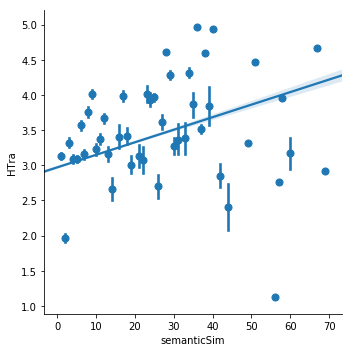

In [158]:
import statsmodels.formula.api as smf
import statsmodels.api as sma
import seaborn as sns
import matplotlib.pyplot as plt

form =depFeat + "~" + indFeat 
form =depFeat + "~" + indFeat + "" 
lmf = smf.ols(formula=form, data=data).fit()

print(lmf.summary())

sns.lmplot(y=depFeat, x=indFeat, x_estimator=np.mean, data=data);

plt.show()


In [189]:
data = data[(data.PoS.str.match('^VB'))]

                            OLS Regression Results                            
Dep. Variable:                   HTra   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     10.50
Date:                Fri, 26 Jul 2019   Prob (F-statistic):            0.00120
Time:                        18:47:17   Log-Likelihood:                -6468.8
No. Observations:                4887   AIC:                         1.294e+04
Df Residuals:                    4885   BIC:                         1.295e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.9979      0.020    202.247      

/usr/local/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


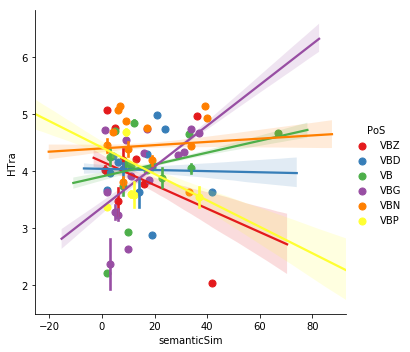

In [191]:
form =depFeat + "~" + indFeat 
form =depFeat + "~" + indFeat + "" 
lmf = smf.ols(formula=form, data=data).fit()

print(lmf.summary())

sns.lmplot(y=depFeat, x=indFeat, hue="PoS", x_estimator=np.mean, palette='Set1', data=data);

plt.show()

### Named Entity Recognition (NER) & merging to ST dataframes

In [424]:
import spacy
nlp = spacy.load('en')

nlp.disable_pipes('tagger')
nlp.disable_pipes('parser')

def generate_stoken_map(stdf):
    """
        Returns a dictionary in the form of [Text][STseg][List of STokens]
        Returns stoken_map
    
    """
    stoken_map = {}
    for text in stdf['Text'].unique().tolist():
        stoken_map.setdefault(text,{})
        for seg in stdf[(stdf.Text == text)]['STseg'].unique().tolist():
            stoken_map[text].setdefault(seg, [])
            sessions = stdf[(stdf.Text == text) & (stdf.STseg == seg)]['Session'].unique().tolist()
            stoken_map[text][seg] = stdf[(stdf.Text == text) & (stdf.STseg == seg) & (stdf.Session == sessions[0])]['SToken'].tolist()
            
    return stoken_map


def map_ne_to_stokens(word_tokens, debug=False):
    """
        Generates Named entity using spacy and creates a dictionary to map those NEs to the STokens
    """
    token_ne_map = {token: "NA" for token in word_tokens }
    sent = ' '.join(word_tokens)
    doc = nlp(sent)
    if debug: 
        print(doc.ents)
    for ent in doc.ents:
        #print(ent)
        entity = str(ent).split(' ')
        label = ent.label_
        count = 0
        for e in entity:
            if count == 0: 
                token_ne_map[e] = label 
            else: 
                token_ne_map[e] = label+":"+str(count)
            count = count+1
    output = [(word, token_ne_map[word]) for word in word_tokens]
    if len(word_tokens) != len(output):
        print("[WARN] The length of source tokens list and named_entity mapped list doesn't match!!")
        
    return output
        

import copy

def generate_stoken_ne_map(stoken_map):
    """
        Maps the generated NEs to the stoken_map 
    """
    output = copy.deepcopy(stoken_map)
    for text in stoken_map.keys():
        for seg in stoken_map[text].keys():
            ne_stokens = map_ne_to_stokens(stoken_map[text][seg])
            output[text][seg] = ne_stokens
    return output  


def merge_ne_to_df(stoken_map, df, col_name="named_entity"):
    """
        Creates a new column 'named_entity' in the data-frame and adds the generated named entities
    """
    df[col_name] = "NA"
    if len(df['Text'].unique()) != len(stoken_map.keys()):
        print("[WARN] The number of texts don't match in data-frame and the stokens_map!!")
    prev_seg = 1
    counter = 0
    for id in df.index:
        text = df.at[id,'Text']
        seg = df.at[id, 'STseg']
        tokenId = df.at[id, 'Id']
        stoken = df.at[id, 'SToken']
        if seg > prev_seg:
            counter = 0
        elif seg < prev_seg:
            counter = 0
            prev_seg = 1
        mapped_ne_list = stoken_map[text][seg]
        # Id in ST tables always start with 1 but index in list starts with 0
        stok = mapped_ne_list[counter][0]
        ne = mapped_ne_list[counter][1]
        if stoken == stok:
            df.at[id, col_name] = ne
        else:
            print(f"[WARN] Stokens doesn't match for Text={text} STSeg={seg} Id={tokenId} Stoken={stoken}")
        counter = counter+1
        prev_seg = seg

In [425]:
## Doesn't work with filtered data frames

# Creates a dictionary of Stokens based on Seg and Text
stoken_map = generate_stoken_map(stdf)
# Generates NE against each source token
output = generate_stoken_ne_map(stoken_map)
# Creates a new column "named_entity" in data-frame and adds the named entity found in previous step
merge_ne_to_df(output, stdf)

In [433]:
text = 2
seg = 2
part = 'P01'
stdf[(stdf.Text == text) & (stdf.Part == part) & (stdf.named_entity != 'NA')][['Id','STseg','Text','SToken','named_entity','Part','HTra','Dur']]

,Id,STseg,Text,SToken,named_entity,Part,HTra,Dur
702,9,2,2,British,NORP,P01,2.6129,2
711,18,2,2,"31,300",MONEY,P01,4.0606,11310
725,32,2,2,17,DATE,P01,3.5725,0
726,33,2,2,years,DATE:1,P01,3.5725,2808
738,45,3,2,the,DATE,P01,4.7871,0
739,46,3,2,past,DATE:1,P01,4.7871,0
740,47,3,2,year,DATE:2,P01,4.7871,2371
756,63,4,2,the,ORG,P01,3.9741,0
757,64,4,2,Bank,ORG:1,P01,3.9741,0
758,65,4,2,of,ORG:2,P01,3.9123,0


In [412]:
# output[Text][STseg]
output[2][2]

[('British', 'NORP'),
 ('families', 'NA'),
 ('have', 'NA'),
 ('to', 'NA'),
 ('cough', 'NA'),
 ('up', 'NA'),
 ('an', 'NA'),
 ('extra', 'NA'),
 ('£', 'NA'),
 ('31,300', 'MONEY'),
 ('a', 'NA'),
 ('year', 'NA'),
 ('as', 'NA'),
 ('food', 'NA'),
 ('and', 'NA'),
 ('fuel', 'NA'),
 ('prices', 'NA'),
 ('soar', 'NA'),
 ('at', 'NA'),
 ('their', 'NA'),
 ('fastest', 'NA'),
 ('rate', 'NA'),
 ('in', 'NA'),
 ('17', 'DATE'),
 ('years', 'DATE:1'),
 ('.', 'NA')]

In [390]:
print(f"lenght_input: {len(stoken_map[2][4])}    length_output{len(output[2][4])}")

lenght_input: 34    length_output34


In [375]:
for s in stoken_map[1].values():
    doc = nlp(' '.join(s))
    print(s)
    nes = [(d,d.label_) for d in doc.ents ]
    print(nes)
    print("\n")

In [441]:
st_ne = stdf[(stdf.named_entity != 'NA')][['Id','STseg','Text','SToken','PoS','named_entity','Part','HTra','Dur','semanticSim']]

In [469]:
grouped = st_ne.groupby('named_entity')

In [470]:
grouped.mean().sort_values('HTra', ascending=False)

,Id,STseg,Text,HTra,Dur,semanticSim
named_entity,,,,,,
MONEY,18.000000,2.000000,2.000000,4.060600,9056.868421,0.000000
PERSON:1,56.902597,4.253247,2.480519,3.608645,13174.331169,0.000000
CARDINAL,64.197183,3.985915,2.272300,3.362727,1824.192488,6.467136
PERSON,61.414986,4.230548,3.219020,3.269508,4777.383285,0.000000
ORG:3,87.000000,4.000000,2.500000,2.996400,7445.092105,0.000000
DATE:1,52.182609,3.673913,2.652174,2.915543,1368.469565,11.604348
DATE:2,56.979167,4.005208,2.781250,2.866336,2001.093750,1.390625
ORG:1,53.339869,3.248366,2.241830,2.831361,1156.712418,1.509804
ORG:2,54.339869,3.248366,2.241830,2.505618,2942.614379,6.954248


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb02aec2668>]],
      dtype=object)

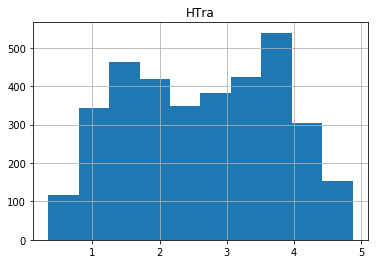

In [465]:
st_ne.hist(column='HTra')


In [440]:
st_ne[['Dur','HTra','semanticSim']].corr()

,Dur,HTra,semanticSim
Dur,1.000000,0.098590,-0.062381
HTra,0.098590,1.000000,0.098062
semanticSim,-0.062381,0.098062,1.000000


In [466]:
import matplotlib.pyplot as plt

(array([116., 343., 462., 418., 348., 382., 423., 539., 305., 153.]),
 array([0.3431, 0.7963, 1.2495, 1.7027, 2.1559, 2.6091, 3.0623, 3.5155,
        3.9687, 4.4219, 4.8751]),
 <a list of 10 Patch objects>)

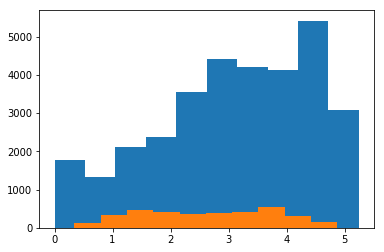

In [468]:
plt.hist(stdf["HTra"])
plt.hist(st_ne["HTra"])